In [5]:
import sys
!{sys.executable} -m pip install seaborn

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
resumes = pd.read_csv("combined_resume_cleaned.csv")
resume_embeddings = np.load("resume_embeddings.npy")


In [11]:
y = resumes['career_label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [12]:
indices = np.arange(len(y_encoded))

X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [13]:
tfidf_text = (
    'skills ' + resumes['skills'].astype(str) +
    ' experience ' + resumes['experience_years'].astype(str) + ' years' +
    ' education ' + resumes['education_level'].astype(str)
)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(tfidf_text)

X_train_tfidf = X_tfidf[X_train_idx]
X_test_tfidf = X_tfidf[X_test_idx]


In [15]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)


In [17]:
from xgboost import XGBClassifier

X_train_bert = resume_embeddings[X_train_idx]
X_test_bert = resume_embeddings[X_test_idx]

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_bert, y_train)
y_pred_xgb = xgb_model.predict(X_test_bert)


In [18]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


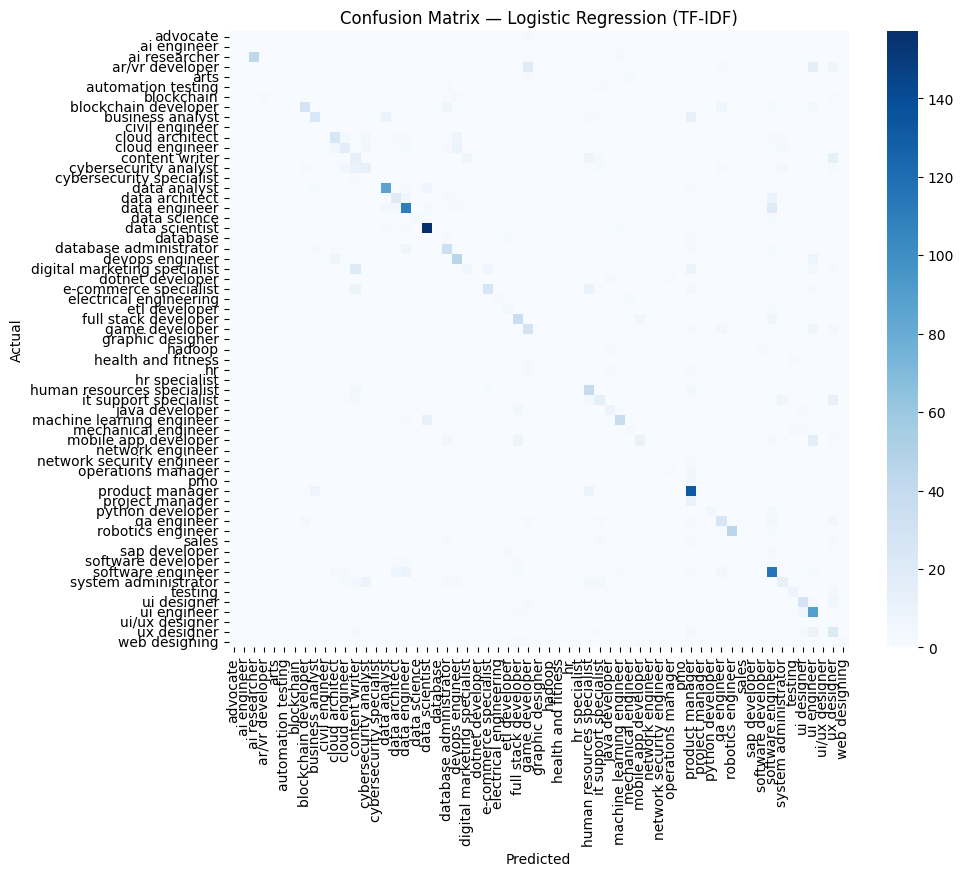

In [19]:
plot_confusion_matrix(
    y_test,
    y_pred_lr,
    label_encoder.classes_,
    "Confusion Matrix — Logistic Regression (TF-IDF)"
)
